# MUSIC algorithm for DOA

**mini-project for COM-500 (Statistical Signal Processing through Applications) at EPFL**

**Authors:**

* *Huang Guyue*
* *Iriarte Sainz Diego Gabriel*
* *Nyambuu Lkham*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import json
import math

---
## Part 1. MUSIC implementation on generated data

### 1.1 Basic MUSIC implementation
MUSIC can be used in detecting direction of arrival (DOA). When applying this algorithm, we use data collected by an array of receivers (e.g. microphones). We hold the following assumptions: 
* The signal source is far away from the array.
* The number of arrays is more than number of coming directions.
* The coming signal has line spectrum or narrow band.
* The distance between array is less than half wave length of the coming signal.
We want to generate data to test basic MUSIC algorithm. Here we generate complex harmonic signals and then detect them.

In [2]:
# DEMO 1: on generated data

# generate data
doa = np.array([20, 60]) / 180 * np.pi    # harmonic signal direction 
w = np.array([1/4, 1/3]) * np.pi          # harmonic signal frequency
N = 200                                   # snapshots
M = 10                                    # number of microphones
P = np.size(doa)                          # number of sources
wavelen = 150                             # wave length
d = wavelen / 2                           # distance between mics
var = 0.01                                # variance of noise

E = np.exp(-1j*2*np.pi*d/wavelen* np.kron(np.arange(M), np.sin(doa)).reshape((M, P)))
x0 = 2*np.exp(1j*(np.kron(w, np.arange(N)).reshape((P, N)))) 
X = np.dot(E, x0)
Y = X + var*np.random.randn(M, N) 

$$ E^{M\times P} = 
\begin{bmatrix}
    1      & 1    &\dots   & 1 \\
    e^{-j2\pi\frac{d*sin(\theta_0)}{\lambda}} &e^{-j2\pi\frac{d*sin(\theta_1)}{\lambda}} &\dots & e^{-j2\pi\frac{d*sin(\theta_{P-1})}{\lambda}} \\
    \vdots & \vdots & \ddots &\vdots \\
    e^{-j2\pi\frac{(M-1)d*sin(\theta_0)}{\lambda}} &e^{-j2\pi\frac{(M-1)d*sin(\theta_1)}{\lambda}} &\dots & e^{-j2\pi\frac{(M-1)d*sin(\theta_{P-1})}{\lambda}} \\
\end{bmatrix}
$$

$$
X_0^{P\times N} = 
\begin{bmatrix}
    1 & e^{jw_0} & \dots & e^{jw_0(N-1)}\\
    1 & e^{jw_1} & \dots & e^{jw_1(N-1)}\\
    \vdots & \vdots & \ddots & \vdots \\
    1 & e^{jw_{P-1}} & \dots & e^{jw_{P-1}(N-1)}\\
\end{bmatrix}
$$

$$Y^{MN} = E^{MP}X_0^{PN} + W^{MN}$$

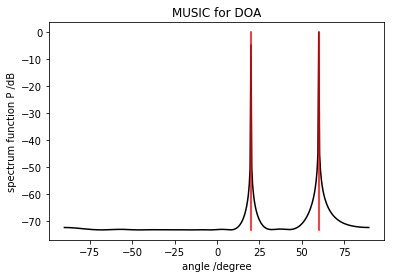

In [3]:
# apply MUSIC
def my_musicdoa(X, M, P, d, wavelen, resscale):
    # X is M*N array, where N is number of snapshots
    
    X0 = (X.T - X.T.mean(axis=0)).T 
    R = np.dot(X0, X0.conj().T)         # R = XX'
    n, v = np.linalg.eig(R)         
    ids = np.abs(n).argsort()[:(M-P)] # find the smallest eignvalues
    En = v[:,ids]
    Ren = np.dot(En, En.conj().T)     # Ren = EnEn'

    theta = np.arange(-90, 90, 0.5)
    L = np.size(theta)
    a = np.exp(-1j*2*np.pi*d/wavelen*np.kron(np.arange(M), np.sin(theta * np.pi /180)).reshape(M, L))
    Pmusic = np.zeros(L)
    for i in range(L):
        Pmusic[i] = 1/abs(np.dot(a[:, i].conj().T, np.dot(Ren, a[:, i]))) # Pmusic = a(theta)'*En*En'*a(theta)

    # spatial spectrum function
    if resscale=="log":
        Pmusic = 10*np.log10(Pmusic / np.max(Pmusic))    
    
    return Pmusic, theta

Pmusic, theta = my_musicdoa(Y, M, P, d, wavelen, "log")

# plot
plt.plot(theta, Pmusic, '-k')
plt.xlabel('angle /degree')
plt.ylabel('spectrum function P /dB')
plt.title('MUSIC for DOA')
plt.plot((20,20),(Pmusic.min(), Pmusic.max()), 'r')
plt.plot((60,60),(Pmusic.min(), Pmusic.max()), 'r')
plt.show()

---
### 1.2 Parameters
We change some parameters and compare the results. The conditions we are looking at are follows:
* variance of noise (awgn)
* number of arrays
* distance between mics in array
* number of snapshots
* angle difference of DOA
* correlated signals (need to apply improved MUSIC)

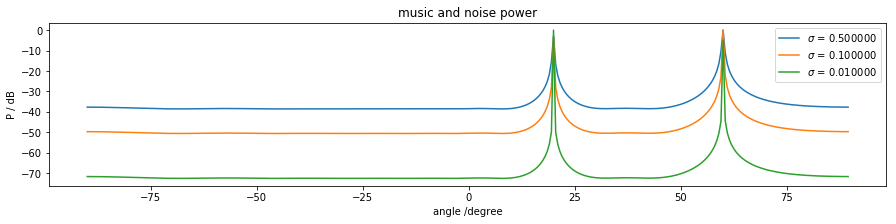

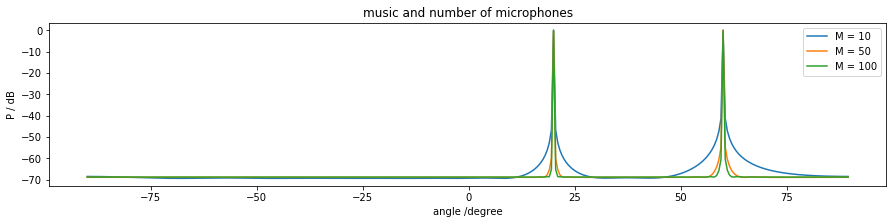

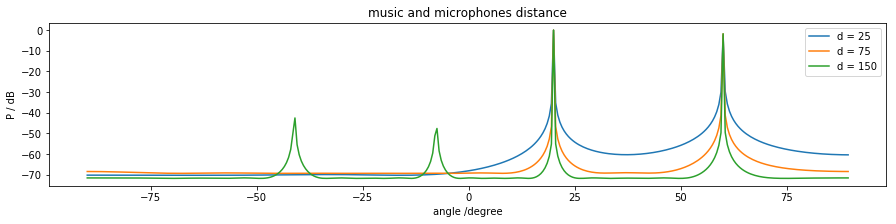

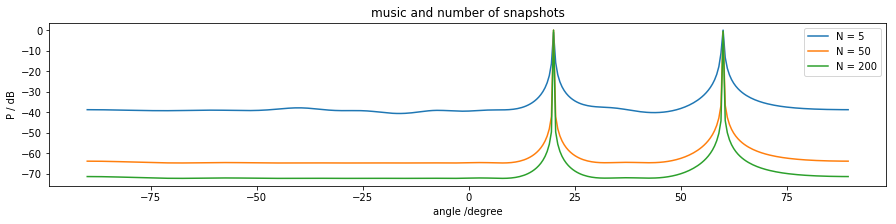

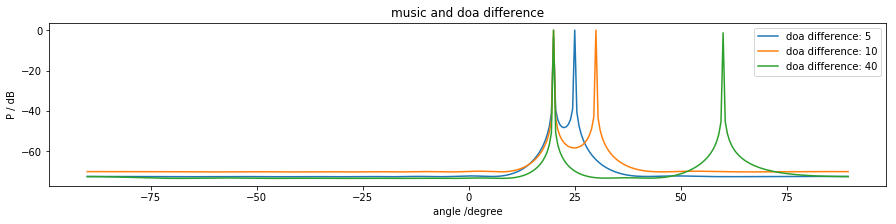

In [4]:
# for this cell, run cell "DEMO1" first to configure
def generate_data(M, N, P, d, wavelen, w, doa, var):
    E = np.exp(-1j*2*np.pi*d/wavelen* np.kron(np.arange(M), np.sin(doa)).reshape((M, P)))
    x0 = 2*np.exp(1j*(np.kron(w, np.arange(N)).reshape((P, N)))) 
    X = np.dot(E, x0)
    Y = X + var*np.random.randn(M, N) 
    return Y

# SNR
plt.figure(figsize=(15,3))
varlist = [0.5, 0.1, 0.01]
for i, sigma in enumerate(varlist):
    Y = generate_data(M, N, P, d, wavelen, w, doa, sigma)
    Pmusic, theta = my_musicdoa(Y, M, P, d, wavelen, "log")
    plt.plot(theta, Pmusic, label="$\sigma$ = %f"%sigma)
    plt.xlabel('angle /degree')
    plt.ylabel('P / dB')
    plt.title('music and noise power')
plt.legend()
plt.show()

# number of arrays (M)
plt.figure(figsize=(15,3))
Mlist = [10, 50, 100]
for i, m in enumerate(Mlist):
    Y = generate_data(m, N, P, d, wavelen, w, doa, var)
    Pmusic, theta = my_musicdoa(Y, m, P, d, wavelen, "log")
    plt.plot(theta, Pmusic, label='M = %d'%m)
    plt.xlabel('angle /degree')
    plt.ylabel('P / dB')
    plt.title('music and number of microphones')
plt.legend()
plt.show()

# distance
plt.figure(figsize=(15,3))
dlist = [wavelen/6, wavelen/2, wavelen]
for i, dd in enumerate(dlist):
    Y = generate_data(M, N, P, dd, wavelen, w, doa, var)
    Pmusic, theta = my_musicdoa(Y, M, P, dd, wavelen, "log")
    plt.plot(theta, Pmusic, label='d = %d'%dd)
    plt.xlabel('angle /degree')
    plt.ylabel('P / dB')
    plt.title('music and microphones distance')
plt.legend()
plt.show()

# snapshots
plt.figure(figsize=(15,3))
nlist = [5, 50, 200]
for i, n in enumerate(nlist):
    Y = generate_data(M, n, P, d, wavelen, w, doa, var)
    Pmusic, theta = my_musicdoa(Y, M, P, d, wavelen, "log")
    plt.plot(theta, Pmusic, label='N = %d'%n)
    plt.xlabel('angle /degree')
    plt.ylabel('P / dB')
    plt.title('music and number of snapshots')
plt.legend()
plt.show()

# angle difference
doalist = np.array([[20, 25],
                    [20, 30],
                    [20, 60]]) / 180 * np.pi
diff = [5, 10, 40]
plt.figure(figsize=(15,3))
for i in range(3):
    doadoa = doalist[i,:]
    Y = generate_data(M, N, P, d, wavelen, w, doadoa, var)
    Pmusic, theta = my_musicdoa(Y, M, P, d, wavelen, "log")
    plt.plot(theta, Pmusic, label='doa difference: %d' % (diff[i]))
    plt.xlabel('angle /degree')
    plt.ylabel('P / dB')
    plt.title('music and doa difference')
plt.legend()
plt.show()

---
### 1.3 Correlated signals
Correlated data infer to signals coming with the same frequency but from different angles. Applying MUSIC directly on correlated data shows poor performance, so a improved version of MUSIC is introduced in *DOA estimation based on MUSIC algorithm* (Tang).

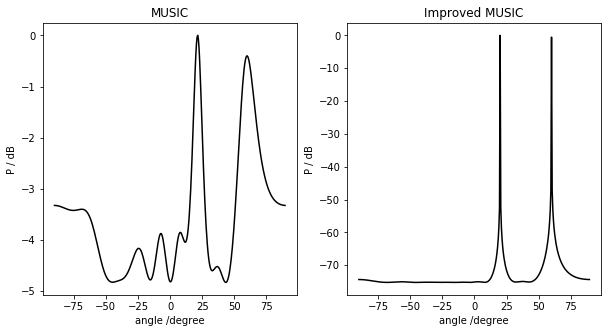

In [5]:
# correlated signal
# a improved version of MUSIC
def my_musicdoa_improved(X, M, P, d, wavelen, resscale):
    # X is M*N array, where N is number of snapshots
    
    X0 = (X.T - X.T.mean(axis=0)).T 
    R = np.dot(X0, X0.conj().T)         # R = XX'
    #--- modified code -----------------
    J = np.flip(np.eye(M), axis=1)
    R = R + np.dot(J, np.dot(R.conj(), J))
    #-----------------------------------
    n, v = np.linalg.eig(R)         
    ids = np.abs(n).argsort()[:(M-P)] # find the smallest eignvalues
    En = v[:,ids]
    Ren = np.dot(En, En.conj().T)     # Ren = EnEn'

    theta = np.arange(-90, 90, 0.5)
    L = np.size(theta)
    a = np.exp(-1j*2*np.pi*d/wavelen*np.kron(np.arange(M), np.sin(theta * np.pi/180)).reshape(M, L))
    Pmusic = np.zeros(L)
    for i in range(L):
        Pmusic[i] = 1/abs(np.dot(a[:, i].conj().T, np.dot(Ren, a[:, i]))) # Pmusic = a(theta)'*En*En'*a(theta)

    # spatial spectrum function
    if resscale=="log":
        Pmusic = 10*np.log10(Pmusic / np.max(Pmusic))    
    
    return Pmusic, theta

w_correlated = np.array([1/4, 1/4]) * np.pi
Y_correlated = generate_data(M, N, P, d, wavelen, w_correlated, doa, var)

plt.figure(figsize=(10,5))
Pmusic, theta = my_musicdoa(Y_correlated, M, P, d, wavelen, "log")
plt.subplot(1,2,1)
plt.plot(theta, Pmusic, '-k')
plt.xlabel('angle /degree')
plt.ylabel('P / dB')
plt.title('MUSIC')

Pmusic, theta = my_musicdoa_improved(Y_correlated, M, P, d, wavelen, "log")
plt.subplot(1,2,2)
plt.plot(theta, Pmusic, '-k')
plt.xlabel('angle /degree')
plt.ylabel('P / dB')
plt.title('Improved MUSIC')
plt.show()

### 1.4 Improved MUSIC (save computation)
When we use MUSIC, we usually take all the eignvectors in noise subspace, but if M>>P, then the dimension of this subspace is large and choosing only some of the noise eignvectors can save computation, and help calibrate possible errors. This improved version of MUSIC is introduced in *DOA Estimation Based on Improved MUSIC Algorithm* (Dai and Du).

$$ a(\theta) = 
\begin{bmatrix}
a_0(\theta) & 0 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
a_{K-1}(\theta) & 0 & \dots & 0 \\
0 & a_K(\theta) & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & a_{M-1}(\theta) \\
\end{bmatrix}
_{M\times(L+1)}
\begin{bmatrix}
1\\
\vdots \\
1\\
\end{bmatrix}
_{(L+1)\times1} = \tilde{a(\theta)}\Gamma 
$$


$$
\hat\theta = \mathop{\arg\min}_{\theta}\frac{1}{det[\tilde{a}^H(\theta) U_N U_N^H \tilde{a}(\theta) ]} 
$$  

$$(K = M - L \geqslant P+1)$$

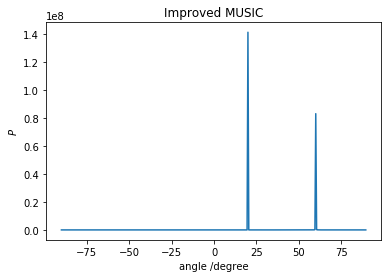

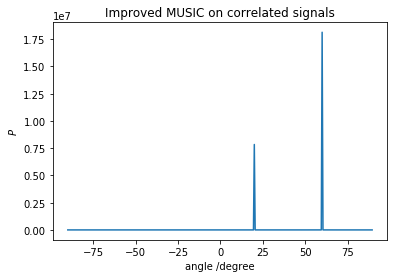

In [7]:
M = 10
P = 2
L = 4
K = M - L

Y = generate_data(M, N, P, d, wavelen, w, doa, var)

X0 = (Y.T - Y.T.mean(axis=0)).T 
R = np.dot(X0, X0.conj().T)         # R = XX'
n, v = np.linalg.eig(R)         
ids = np.abs(n).argsort()[:(L+1)] # find the smallest eignvalues
En = v[:,ids]
Ren = np.dot(En, En.conj().T)     # Ren = EnEn'

theta = np.arange(-90, 90, 0.5)
l = np.size(theta)
Pmusic = np.zeros(l)
#--- improved part -----
for i in range(l):
    asteer = np.exp(-1j*2*np.pi*d*np.sin(theta[i]*np.pi/180)/wavelen*np.arange(M))
    atilde = np.zeros((M, L+1), dtype=complex)
    atilde[:K, 0] = asteer[:K]
    atilde[K:, 1:] = np.diag(asteer[K:])
    Pmusic[i] = 1/abs(np.linalg.det(np.dot(atilde.conj().T, np.dot(Ren, atilde))))
    
plt.plot(theta, Pmusic)
plt.title('Improved MUSIC')
plt.xlabel('angle /degree')
plt.ylabel('$P$')
plt.show()

# correlated data
w_correlated = np.array([1/4, 1/4]) * np.pi
Y = generate_data(M, N, P, d, wavelen, w_correlated, doa, var)
X0 = (Y.T - Y.T.mean(axis=0)).T 
R = np.dot(X0, X0.conj().T)         # R = XX'
J = np.flip(np.eye(M), axis=1)
R = R + np.dot(J, np.dot(R.conj(), J))
n, v = np.linalg.eig(R)         
ids = np.abs(n).argsort()[:(M-P)] # find the smallest eignvalues
En = v[:,ids]
Ren = np.dot(En, En.conj().T)     # Ren = EnEn'

theta = np.arange(-90, 90, 0.5)
l = np.size(theta)
Pmusic = np.zeros(l)
#--- improved part -----
for i in range(l):
    asteer = np.exp(-1j*2*np.pi*d*np.sin(theta[i]*np.pi/180)/wavelen*np.arange(M))
    atilde = np.zeros((M, L+1), dtype=complex)
    atilde[:K, 0] = asteer[:K]
    atilde[K:, 1:] = np.diag(asteer[K:])
    Pmusic[i] = 1/abs(np.linalg.det(np.dot(atilde.conj().T, np.dot(Ren, atilde))))
    
plt.plot(theta, Pmusic)
plt.title('Improved MUSIC on correlated signals')
plt.xlabel('angle /degree')
plt.ylabel('$P$')
plt.show()

Suppose the last L of the array is intefered by some error, this algorithm can also help calibrate this error. 

C:\Anaconda\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


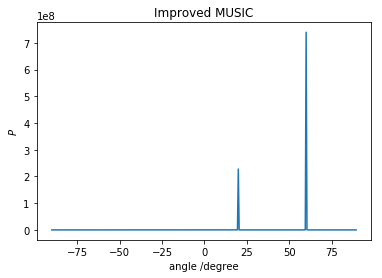

actual amplitude error:
0.8901
1.1223
1.1077
1.0537
estimated:
0.8902
1.1223
1.1069
1.0532

 actual phase error:
-2.0890
2.6434
0.1914
-0.4154
estimated:
-2.0890
2.6422
0.1909
-0.4156


In [8]:
doa1 = np.array([20, 60]) / 180 * np.pi
#--- add errors ---
phase_err = np.pi*2*np.random.rand(L) - np.pi
amp_err = 1 + 0.1*np.random.randn(L)
Y = generate_data(M, N, P, d, wavelen, w, doa1, var)

#--- add errors ---
phase_err = np.pi*2*np.random.rand(4) - np.pi
amp_err = 1 + 0.1*np.random.randn(4)
Y[-L:, :] = Y[-L:, :] * np.tile(amp_err, (N, 1)).T * np.tile(np.exp(1j*phase_err), (N, 1)).T

# run improved-MUSIC to calibrate
X0 = (Y.T - Y.T.mean(axis=0)).T 
R = np.dot(X0, X0.conj().T)         # R = XX'
n, v = np.linalg.eig(R)         
ids = np.absolute(n).argsort()[:(L+1)] # find the smallest eignvalues
En = v[:,ids]
Ren = np.dot(En, En.conj().T)     # Ren = EnEn'

theta = np.arange(-90, 90, 0.5)
l = np.size(theta)
Pmusic = np.zeros(l, dtype=complex)
#--- improved part -----
for i in range(l):
    asteer = np.exp(-1j*2*np.pi*d*np.sin(theta[i]*np.pi/180)/wavelen*np.arange(M))
    atilde = np.zeros((M, L+1), dtype=complex)
    atilde[:K, 0] = asteer[:K]
    atilde[K:, 1:] = np.diag(asteer[K:])
    Pmusic[i] = 1/abs(np.linalg.det(np.dot(atilde.conj().T, np.dot(Ren, atilde))))
    
plt.plot(theta, Pmusic)
plt.title('Improved MUSIC')
plt.xlabel('angle /degree')
plt.ylabel('$P$')
plt.show()

# calibrate the error
theta_hat = theta[np.argmax(Pmusic)]
asteer = np.exp(-1j*2*np.pi*d*np.sin(theta_hat*np.pi/180)/wavelen*np.arange(M))
atilde = np.zeros((M, L+1), dtype=complex)
atilde[:K, 0] = asteer[:K]
atilde[K:, 1:] = np.diag(asteer[K:])
ww, vv = np.linalg.eig(np.dot(atilde.conj().T, np.dot(Ren, atilde)))
gamma = vv[:, np.argsort(np.absolute(ww))[0]]

gamma = gamma / gamma[0]

a_calib = np.absolute(gamma)
p_calib = np.angle(gamma)

print('actual amplitude error:')
for x in amp_err.tolist():
    print('%.4f' % x)
print('estimated:')
for x in a_calib.tolist()[1:]:
    print('%.4f' % x)

print('\n actual phase error:')
for x in phase_err.tolist():
    print('%.4f' % x)
print('estimated:')
for x in p_calib.tolist()[1:]:
    print('%.4f' % x)